In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df = pd.read_csv("../data/raw/CVD_raw.csv")

In [22]:
df.isnull().sum()

General_Health                  0
Checkup                         0
Exercise                        0
Heart_Disease                   0
Skin_Cancer                     0
Other_Cancer                    0
Depression                      0
Diabetes                        0
Arthritis                       0
Sex                             0
Age_Category                    0
Height_(cm)                     0
Weight_(kg)                     0
BMI                             0
Smoking_History                 0
Alcohol_Consumption             0
Fruit_Consumption               0
Green_Vegetables_Consumption    0
FriedPotato_Consumption         0
dtype: int64

## Removing Duplicates

In [4]:
duplicates_sum = df.duplicated().sum()
duplicates_pct = round((duplicates_sum/len(df)) * 100,3)
print(f"No. of duplicates: {duplicates_sum}\nPercentage of Duplicates : {duplicates_pct}%")

No. of duplicates: 80
Percentage of Duplicates : 0.026%


In [5]:
duplicates = df.duplicated()
df[duplicates]["Heart_Disease"].value_counts()

Heart_Disease
No    80
Name: count, dtype: int64

In [6]:
df.drop_duplicates(inplace=True)

### Cleaning height, weight and BMI

In [7]:
bmi_greater_60 = len(df[(df["BMI"] > 60) | (df["BMI"]<15)])
weight_greater_200 = len(df[(df["Weight_(kg)"] > 220) | (df["Weight_(kg)"] < 35)])
height_extreme = len(df[(df["Height_(cm)"] > 210) | (df["Height_(cm)"] < 120)])
total_extremes = bmi_greater_60 + weight_greater_200 + height_extreme
total_extremes_pct = round((total_extremes/len(df))*100,2)
print(f"There are {total_extremes} extreme data and they constitute around {total_extremes_pct}% of the data")

There are 1085 extreme data and they constitute around 0.35% of the data


In [8]:
df_cleaned = df[(df["Height_(cm)"].between(120,210)) & (df["Weight_(kg)"].between(35,220)) & (df["BMI"].between(15,60))]

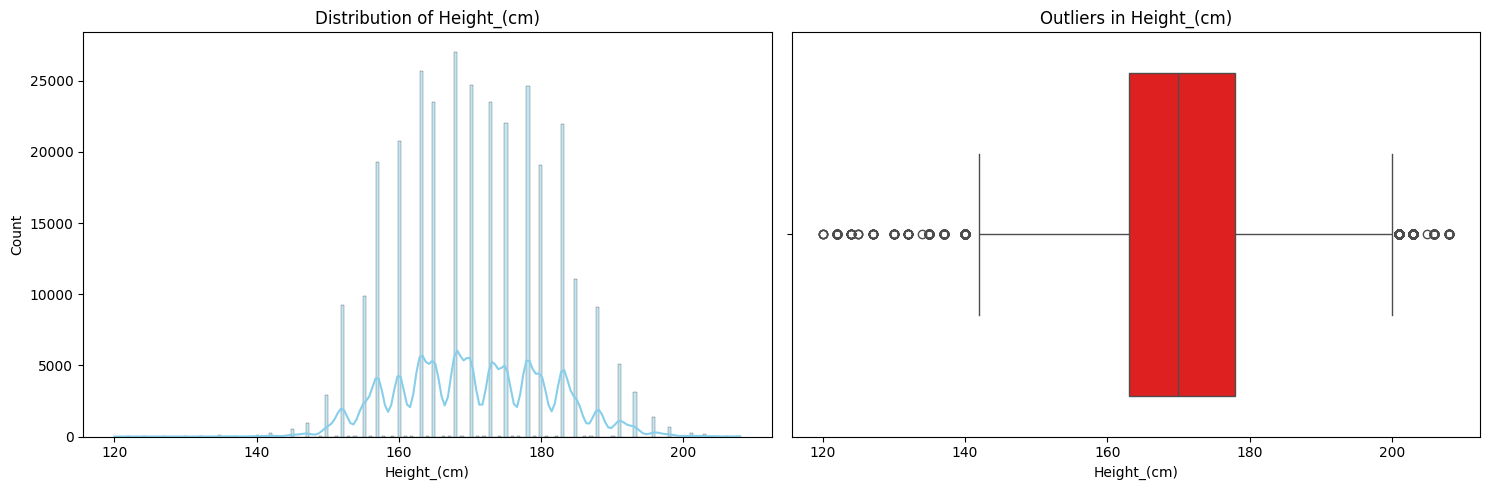

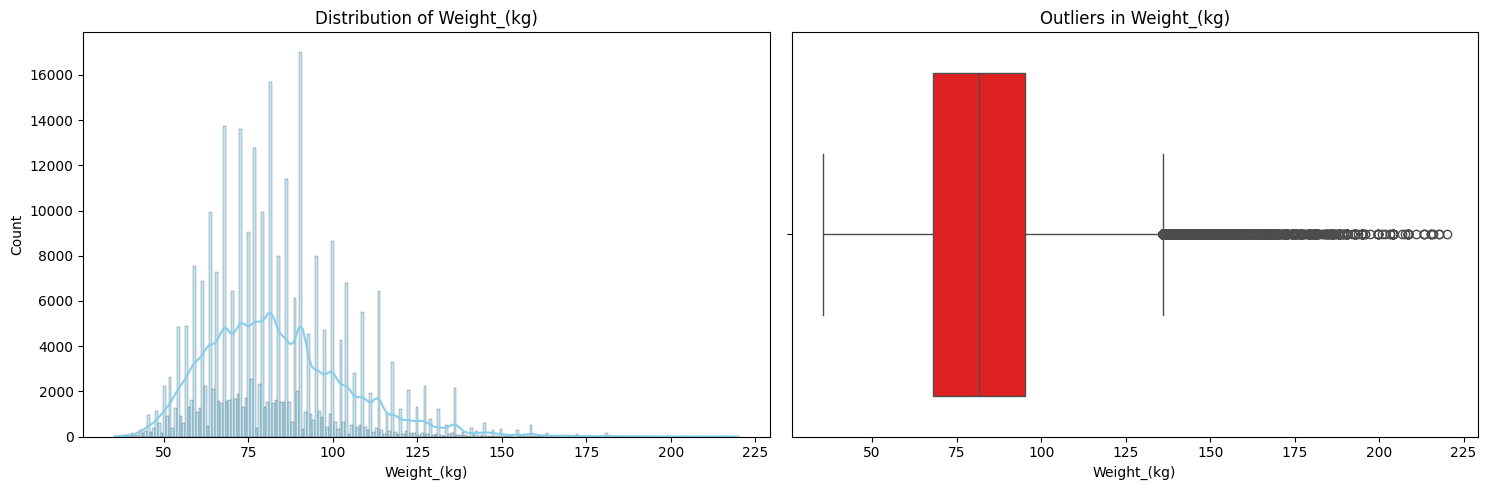

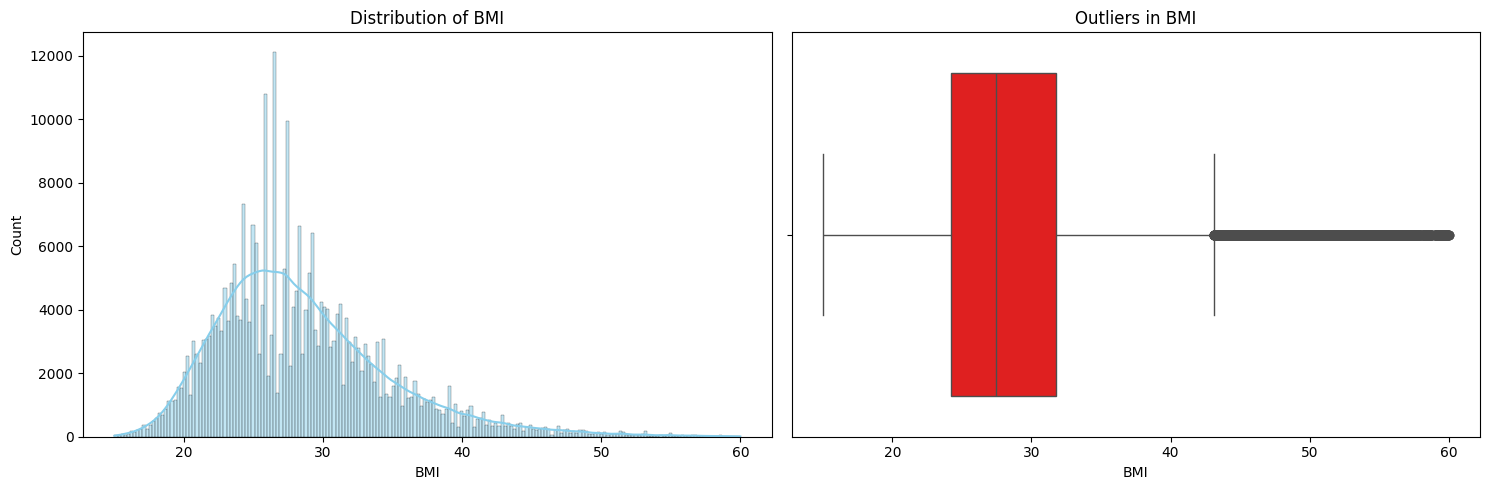

In [9]:
nums = ["Height_(cm)","Weight_(kg)","BMI"]
for col in nums:
    fig, axes = plt.subplots(1,2,figsize=(15,5))
    sns.histplot(data=df_cleaned,x=col,kde=True,ax=axes[0],color='skyblue')
    axes[0].set_title(f'Distribution of {col}')
    sns.boxplot(data=df_cleaned,x=col,ax=axes[1],color='red')
    axes[1].set_title(f'Outliers in {col}')
    plt.tight_layout()
    plt.show()

In [10]:
stats = df_cleaned[nums].describe().T
median = df_cleaned[nums].median()
skew = df_cleaned[nums].skew()
stats["median"] = df_cleaned[nums].median()
stats["skew"] = skew
stats

,count,mean,std,min,25%,50%,75%,max,median,skew
Height_(cm),307873.0,170.624949,10.581598,120.00,163.00,170.00,178.00,208.00,170.00,0.053889
Weight_(kg),307873.0,83.445060,20.851231,35.38,68.04,81.65,95.25,219.99,81.65,0.883353
BMI,307873.0,28.566077,6.283778,15.00,24.21,27.44,31.77,60.00,27.44,1.065429


* Capped the height to a realistic values: BMI: 15-60, Height: 120-210, Weight: 35-220
* The target class balance is not affected

### Cleaning binary columns

In [11]:
binary_cols = ['Skin_Cancer','Other_Cancer', 'Depression', 'Arthritis', 'Sex',"Smoking_History"]
for col in binary_cols:
    print(f"---{col}---")
    print(df_cleaned[col].unique())

---Skin_Cancer---
<StringArray>
['No', 'Yes']
Length: 2, dtype: str
---Other_Cancer---
<StringArray>
['No', 'Yes']
Length: 2, dtype: str
---Depression---
<StringArray>
['No', 'Yes']
Length: 2, dtype: str
---Arthritis---
<StringArray>
['No', 'Yes']
Length: 2, dtype: str
---Sex---
<StringArray>
['Female', 'Male']
Length: 2, dtype: str
---Smoking_History---
<StringArray>
['No', 'Yes']
Length: 2, dtype: str


* All binary columns are consistent with Yes/No values and sex with Male/Female value

### Cleaning categorical columns

In [12]:
df_cleaned.columns

Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption'],
      dtype='str')

In [13]:
category_cols = ['General_Health', 'Checkup','Diabetes','Age_Category']
for col in category_cols:
    print(f"---{col}---")
    print(df_cleaned[col].unique())

---General_Health---
<StringArray>
['Very Good', 'Poor', 'Good', 'Fair', 'Excellent']
Length: 5, dtype: str
---Checkup---
<StringArray>
[   'Within the past year', 'Within the past 2 years',
     '5 or more years ago', 'Within the past 5 years',
                   'Never']
Length: 5, dtype: str
---Diabetes---
<StringArray>
[                                       'Yes',
                                         'No',
    'No, pre-diabetes or borderline diabetes',
 'Yes, but female told only during pregnancy']
Length: 4, dtype: str
---Age_Category---
<StringArray>
['70-74', '60-64', '75-79',   '80+', '65-69', '50-54', '45-49', '18-24',
 '30-34', '55-59', '35-39', '40-44', '25-29']
Length: 13, dtype: str


In [14]:
df_cleaned["Diabetes"] = df_cleaned["Diabetes"].replace(
    {"No, pre-diabetes or borderline diabetes": "Prediabetic", "Yes, but female told only during pregnancy": "Gestational"}
)

In [15]:
df_cleaned["Diabetes"].unique()

<StringArray>
['Yes', 'No', 'Prediabetic', 'Gestational']
Length: 4, dtype: str

* Verified no missing values across all categorical variables and standardized formatting (trimmed whitespace and consistent capitalization)
* Confirmed ordinal variables are consistent and preserved for ordered encoding in preprocessing
* Validated binary variables contain only consistent and valid categories
* Standard Diabetes category to: Yes, No, Prediabetic and Gestational to preserve medical meaning

### Cleaning the consumption variables

In [18]:
consumption = ["Alcohol_Consumption", "Fruit_Consumption", "Green_Vegetables_Consumption","FriedPotato_Consumption"]
stats = df_cleaned[consumption].describe().T
stats["median"] = df_cleaned[consumption].median()
stats["skew"] = df_cleaned[consumption].skew()
stats

,count,mean,std,min,25%,50%,75%,max,median,skew
Alcohol_Consumption,307873.0,5.103919,8.203624,0.0,0.0,1.0,6.0,30.0,1.0,1.883174
Fruit_Consumption,307873.0,29.843725,24.875768,0.0,12.0,30.0,30.0,120.0,30.0,1.247939
Green_Vegetables_Consumption,307873.0,15.113950,14.921639,0.0,4.0,12.0,20.0,128.0,12.0,2.415102
FriedPotato_Consumption,307873.0,6.293891,8.577665,0.0,2.0,4.0,8.0,128.0,4.0,4.917109


* Verified Alcohol, Fruit, Green Vegetables and Fried Potato consumption variables contain no negative or unrealistic values.
* Maximum values are physiologically possible, no capping or removal required.
* Distribution is highly right skewed, which is expected for behavioural data.

In [23]:
df_cleaned.to_csv("../data/processed/CVD_cleaned.csv")